# Testing trained decoder on shuffled data

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load our data set
loan_dataset = pd.read_csv("../datasets/loan.csv")
loan_dataset.head()

# define numerical and categorical features
numeric_features = [
    "education", "age", "income", "loan_size", 
    "payment_timing", "year", "job_stability"]
categorical_features = ["minority","sex","ZIP", "rent", "occupation"] #ASK MARTINA - I added minority & sex here

# use all features (X) to predict default (y) (default = unsuccessful loan payment (1))
X = loan_dataset.copy().drop(["default"], axis=1)
y = loan_dataset.copy()["default"]

In [4]:
# split data into training and test half
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [5]:
# check training and test data size
print(np.shape(X_train))
print(np.shape(X_test))

(360000, 12)
(120000, 12)


In [5]:
# display variable distributions - takes too long
#train_dataset = X_train.copy()
#train_dataset.insert(0, "default", y_train)
#_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

In [7]:
# shuffle sensitive / important features
import random
from sklearn.utils import shuffle
X_test_shuffleMinority = X_test.copy()
X_test_shuffleMinority["minority"] = np.random.permutation(X_test["minority"].values)
X_test_shuffleJob = X_test.copy()
X_test_shuffleJob["job_stability"] = np.random.permutation(X_test["job_stability"].values)
X_test_shuffleSex = X_test.copy()
X_test_shuffleSex["sex"] = np.random.permutation(X_test["sex"].values)
# inspect if shuffling worked
#[X_test_shuffle["minority"],X_test["minority"]]


In [8]:
# Create preprocessor of features
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [9]:
# Create pipeline
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
)


In [10]:
# train model
clf = clf.fit(X_train, y_train)

In [11]:
# check model performance
from sklearn.metrics import median_absolute_error
from sklearn.metrics import recall_score


y_pred = clf.predict(X_test)
y_predShuffleMinority = clf.predict(X_test_shuffleMinority)
y_predShuffleJob = clf.predict(X_test_shuffleJob)
y_predShuffleSex = clf.predict(X_test_shuffleSex)

score = recall_score(y_test, y_pred)
scoreShuffleMinority  = recall_score(y_test, y_predShuffleMinority)
scoreShuffleJob  = recall_score(y_test, y_predShuffleJob)
scoreShuffleSex  = recall_score(y_test, y_predShuffleSex)

print(score)
print(scoreShuffleMinority)
print(scoreShuffleJob)
print(scoreShuffleSex)


1.0
1.0
0.5551126603178839
1.0


In [12]:
# get predictor weights
feature_weights = clf[-1].coef_[0]
print(feature_weights)
np.shape(feature_weights)


[ 0.95767577  0.07992972  0.64166704 -0.75653382 -0.0786503   0.27700887
 -6.67297882 -1.27630454  1.27667445 -0.91071978  0.91108969 -3.01198045
  2.10650973 -1.30095508  2.20679572 -0.07325879  0.0736287  -1.27630454
  1.60310087 -0.32642642]


(20,)

In [13]:
# extract feature names
feature_names = clf[0].named_transformers_['cat'].get_feature_names(input_features=categorical_features)
feature_names = np.concatenate(
    [numeric_features,feature_names]) # which order??
print(feature_names)
print(feature_names.shape)

['education' 'age' 'income' 'loan_size' 'payment_timing' 'year'
 'job_stability' 'minority_0' 'minority_1' 'sex_0' 'sex_1' 'ZIP_MT01RA'
 'ZIP_MT04PA' 'ZIP_MT12RA' 'ZIP_MT15PA' 'rent_0' 'rent_1'
 'occupation_MZ01CD' 'occupation_MZ10CD' 'occupation_MZ11CD']
(20,)


In [14]:
coefs = pd.DataFrame(
    feature_weights,
    columns=['Coefficients'], index=feature_names
)

<AxesSubplot:>

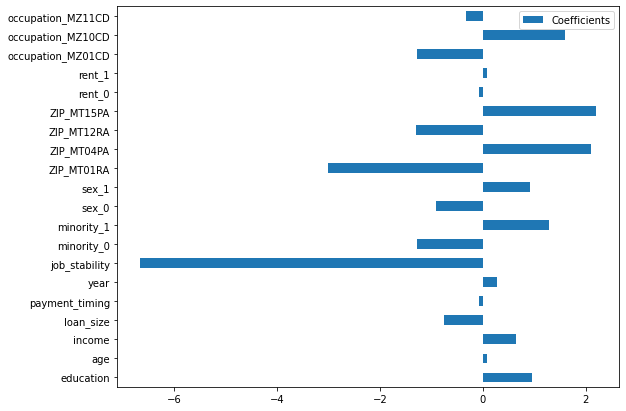

In [15]:
coefs.plot(kind='barh', figsize=(9, 7))


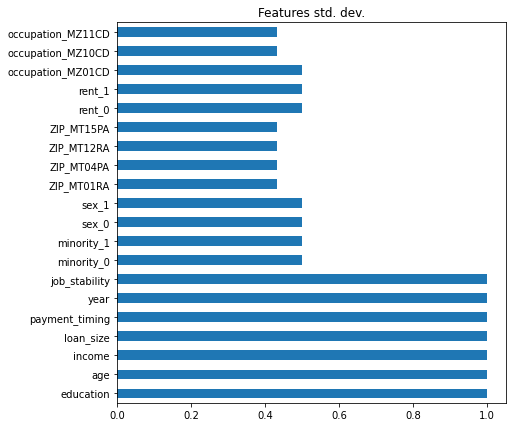

In [16]:
# getting standard deviation of features
X_train_preprocessed = pd.DataFrame(clf[0].transform(X_train),columns=feature_names)

X_train_preprocessed.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.')
plt.subplots_adjust(left=.3)

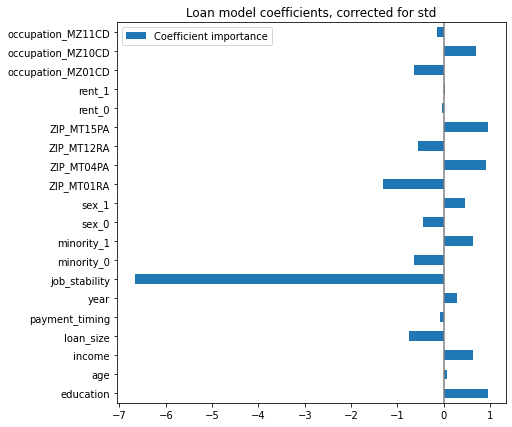

In [17]:
# correcting feature coefficients by standard deviation
# quote tutorial: In that way, we emphasize that the greater the variance of 
# a feature, the larger the weight of the corresponding coefficient on the output, all else being equal.
coefsCorr = pd.DataFrame(feature_weights *X_train_preprocessed.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
coefsCorr.plot(kind='barh', figsize=(9, 7))
plt.title('Loan model coefficients, corrected for std')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [64]:
# checking variability of coefficients
#from sklearn.model_selection import cross_validate
#from sklearn.model_selection import RepeatedKFold

#cv_model = cross_validate(
#    clf, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
#    return_estimator=True, n_jobs=-1
#)
#coefsModel = pd.DataFrame(
#    [est[1].coef_ *
#     X_train_preprocessed.std(axis=0)
#     for est in cv_model['estimator']],
#    columns=feature_names
#)

#plt.figure(figsize=(9, 7))
#sns.stripplot(data=coefsModel, orient='h', color='k', alpha=0.5)
#sns.boxplot(data=coefsModel, orient='h', color='cyan', saturation=0.5)
#plt.axvline(x=0, color='.5')
#plt.xlabel('Coefficient importance')
#plt.title('Coefficient importance and its variability')
#plt.subplots_adjust(left=.3)

In [65]:
#np.shape(cv_model['estimator'])
